In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt

## Učitavanje podataka

In [83]:
data = pd.read_csv('data.csv')

In [84]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [85]:
y = data.iloc[:, -1]
X = data.iloc[:, :data.shape[1] - 1]

### Pravljenje atributa i metrika za evaluaciju i izbor najboljeg modela

In [103]:
cnn_par_f = {
    'window': [3, 7, 11],
    'dropout': [0.2, 0.5]
}

In [87]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [88]:
filter_cnn = 64
num_classes = len(np.unique(y))
epochs = 25
K=10
pool = 3
classes = np.unique(y)

In [89]:
num_classes

5

In [90]:
scoring = {'f1_macro' : 'f1_macro', 'accuracy' : 'accuracy'}
for c in classes:
    def f1_class(y_true, y_pred, classes, c=c):
        return metrics.f1_score(y_true, y_pred, average=None)[c-1]
    scoring_name = 'f1_class_%d' % c
    scoring[scoring_name] = metrics.make_scorer(f1_class, classes = classes)

### Podela podataka na trening i testni skup, standardizacija i Furijeova transformacija

In [91]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, stratify = y,random_state = 1996)

In [92]:
from sklearn import preprocessing
scaler_train = preprocessing.StandardScaler()
scaler_train.fit(X_train)
X_train = scaler_train.transform(X_train)
X_test = scaler_train.transform(X_test)

In [93]:
print(X_train.shape, X_test.shape)

(8050, 178) (3450, 178)


In [94]:
X_train_fft = np.fft.rfft(X_train, axis=1).astype(float)
X_test_fft = np.fft.rfft(X_test, axis=1).astype(float)

C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [95]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90) (3450, 90)


In [96]:
X_train_fft = np.array(X_train_fft)
X_test_fft = np.array(X_test_fft)
X_train_fft = X_train_fft.reshape(X_train_fft.shape[0], X_train_fft.shape[1], 1)
X_test_fft = X_test_fft.reshape(X_test_fft.shape[0], X_test_fft.shape[1], 1)

In [97]:
print(X_train_fft.shape, X_test_fft.shape)

(8050, 90, 1) (3450, 90, 1)


## Pravljenje mreže i izbor najboljeg modela unakrsnom validacijom

In [98]:
input_shape = (X_train_fft.shape[1], 1)
input_shape

(90, 1)

In [99]:
from keras import optimizers

In [108]:
def mreza(input_shape, num_classes,window, dropout):
    model = Sequential()
    model.add(Conv1D(filter_cnn, window, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filter_cnn, window, activation='relu'))
    model.add(MaxPooling1D(pool))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])
    return model

In [109]:
from keras.wrappers.scikit_learn  import KerasClassifier
def get_estimator(window=3,dropout=0.5):
    return KerasClassifier(build_fn=mreza,input_shape=input_shape, num_classes=num_classes,window=window, dropout=dropout, epochs = epochs)

In [110]:
estimator = get_estimator()
grid_f_cnn = model_selection.GridSearchCV(estimator, param_grid=cnn_par_f, scoring=scoring, cv=K, refit='accuracy', return_train_score=True)

In [ ]:
grid_f_cnn.fit(X_train_fft, y_train)

Epoch 1/25
7245/7245 [==============================] - 19s 3ms/step - loss: 1.0536 - accuracy: 0.5365
Epoch 2/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.9057 - accuracy: 0.5935
Epoch 3/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8534 - accuracy: 0.6218
Epoch 4/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8346 - accuracy: 0.6277
Epoch 5/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8316 - accuracy: 0.6275
Epoch 6/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8219 - accuracy: 0.6297
Epoch 7/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8092 - accuracy: 0.6330
Epoch 8/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7966 - accuracy: 0.6367
Epoch 9/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7999 - accuracy: 0.6380
Epoch 10/25
7245/7245 [==============================] - 15s 2ms/step - l

Epoch 5/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8294 - accuracy: 0.6242
Epoch 6/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8191 - accuracy: 0.6228
Epoch 7/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.8200 - accuracy: 0.6287
Epoch 8/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7971 - accuracy: 0.6346
Epoch 9/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.8013 - accuracy: 0.6386
Epoch 10/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7920 - accuracy: 0.6377
Epoch 11/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7883 - accuracy: 0.6440
Epoch 12/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7748 - accuracy: 0.6449
Epoch 13/25
7245/7245 [==============================] - 15s 2ms/step - loss: 0.7824 - accuracy: 0.6431
Epoch 14/25
7245/7245 [==============================] - 15s 2ms/step

7245/7245 [==============================] - 16s 2ms/step - loss: 0.7893 - accuracy: 0.6449
Epoch 10/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7875 - accuracy: 0.6457
Epoch 11/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7717 - accuracy: 0.6471
Epoch 12/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7813 - accuracy: 0.6431
Epoch 13/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7592 - accuracy: 0.6497
Epoch 14/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7698 - accuracy: 0.6513
Epoch 15/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7721 - accuracy: 0.6479
Epoch 16/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7683 - accuracy: 0.6505
Epoch 17/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7786 - accuracy: 0.6542
Epoch 18/25
7245/7245 [==============================] - 16s 2ms/step - loss

7245/7245 [==============================] - 16s 2ms/step - loss: 0.7316 - accuracy: 0.6663
Epoch 14/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7356 - accuracy: 0.6638
Epoch 15/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7243 - accuracy: 0.6756
Epoch 16/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7179 - accuracy: 0.6820
Epoch 17/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.7016 - accuracy: 0.6810
Epoch 18/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6918 - accuracy: 0.6854
Epoch 19/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6843 - accuracy: 0.6894
Epoch 20/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6764 - accuracy: 0.6948
Epoch 21/25
7245/7245 [==============================] - 16s 2ms/step - loss: 0.6872 - accuracy: 0.6918
Epoch 22/25
7245/7245 [==============================] - 16s 2ms/step - loss

7245/7245 [==============================] - 17s 2ms/step - loss: 0.7459 - accuracy: 0.6705
Epoch 18/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7368 - accuracy: 0.6674
Epoch 19/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7452 - accuracy: 0.6656
Epoch 20/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7703 - accuracy: 0.6562
Epoch 21/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7822 - accuracy: 0.6533
Epoch 22/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7830 - accuracy: 0.6489
Epoch 23/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7402 - accuracy: 0.6700
Epoch 24/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7605 - accuracy: 0.6636
Epoch 25/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7397 - accuracy: 0.6634
Epoch 1/25
7245/7245 [==============================] - 21s 3ms/step - loss:

7245/7245 [==============================] - 17s 2ms/step - loss: 0.6041 - accuracy: 0.7252
Epoch 22/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.6028 - accuracy: 0.7245
Epoch 23/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.6074 - accuracy: 0.7208
Epoch 24/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.5941 - accuracy: 0.7288
Epoch 25/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.6256 - accuracy: 0.7222
Epoch 1/25
7245/7245 [==============================] - 21s 3ms/step - loss: 1.0816 - accuracy: 0.5278
Epoch 2/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7925 - accuracy: 0.6473
Epoch 3/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7813 - accuracy: 0.6450
Epoch 4/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7574 - accuracy: 0.6542
Epoch 5/25
7245/7245 [==============================] - 17s 2ms/step - loss: 0.7

In [46]:
grid_f_cnn.best_params_

{'dropout': 0.2, 'window': 7}

In [48]:
grid_f_cnn.best_score_

0.7469565217391304

### Rezultati unakrsne validacije

In [51]:
grid_f_cnn_results =pd.DataFrame(grid_f_cnn.cv_results_)
print(grid_f_cnn_results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_dropout  \
0     166.553181      5.448159         3.402238        0.189330           0.1   
1     215.702619      5.782552         4.111922        0.220646           0.1   
2     239.432600      7.366358         4.792014        0.200890           0.1   
3     218.364463      6.791688         5.590700        0.250550           0.2   
4     272.529417      7.798654         6.412987        0.259565           0.2   
5     306.060310     12.415061         7.277373        0.309104           0.2   
6     288.645937      8.399069         8.351752        0.361654           0.5   
7     353.287802      7.603029         9.367235        0.337211           0.5   
8     395.925554     11.649895        10.347327        0.344337           0.5   

  param_window                          params  split0_test_f1_macro  \
0            3   {'dropout': 0.1, 'window': 3}              0.714920   
1            7   {'dropout': 0.1, 'window': 7

In [52]:
grid_f_cnn_results.to_csv('grid_f_cnn_scoring_results.csv')

In [63]:
grid_f_cnn_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_window,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,...,split2_train_f1_class_5,split3_train_f1_class_5,split4_train_f1_class_5,split5_train_f1_class_5,split6_train_f1_class_5,split7_train_f1_class_5,split8_train_f1_class_5,split9_train_f1_class_5,mean_train_f1_class_5,std_train_f1_class_5
0,166.553181,5.448159,3.402238,0.189330,0.1,3,"{'dropout': 0.1, 'window': 3}",0.714920,0.717195,0.675465,...,0.823315,0.852122,0.825057,0.849108,0.846977,0.857349,0.840992,0.847468,0.841468,0.010839
1,215.702619,5.782552,4.111922,0.220646,0.1,7,"{'dropout': 0.1, 'window': 7}",0.730607,0.738135,0.740888,...,0.973505,0.960214,0.964568,0.966173,0.960593,0.960429,0.955418,0.979536,0.962214,0.011392
2,239.432600,7.366358,4.792014,0.200890,0.1,11,"{'dropout': 0.1, 'window': 11}",0.737381,0.745754,0.747920,...,0.996518,0.985789,0.994844,0.990596,0.993810,0.996182,0.988010,0.990166,0.992389,0.003760
3,218.364463,6.791688,5.590700,0.250550,0.2,3,"{'dropout': 0.2, 'window': 3}",0.705112,0.705186,0.731221,...,0.835270,0.859249,0.833433,0.841941,0.820866,0.848568,0.827030,0.848604,0.832866,0.016821
4,272.529417,7.798654,6.412987,0.259565,0.2,7,"{'dropout': 0.2, 'window': 7}",0.737678,0.772217,0.743186,...,0.974429,0.923669,0.950544,0.969655,0.959920,0.978402,0.969656,0.964965,0.958815,0.016060


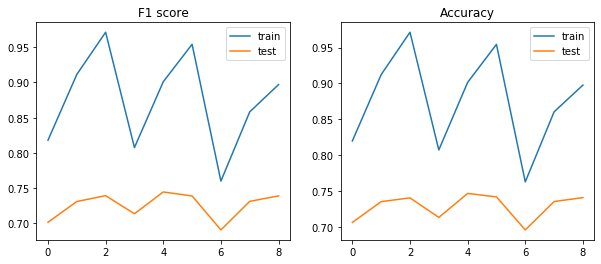

In [66]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('F1 score')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_f1_macro'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_f1_macro'], label='test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_train_accuracy'], label='train')
plt.plot(range(len(grid_f_cnn_results['params'])), grid_f_cnn_results['mean_test_accuracy'], label='test')
plt.legend(loc='best')

## Čuvanje i evaluacija najboljeg modela

In [55]:
best_model = grid_f_cnn.best_estimator_

In [57]:
import joblib
joblib.dump(best_model, 'cnn_fft.joblib')

['cnn_fft.joblib']

In [58]:
y_pred = grid_f_cnn.predict(X_test_fft)

In [76]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95       690
           2       0.57      0.60      0.58       690
           3       0.61      0.64      0.63       690
           4       0.91      0.78      0.84       690
           5       0.76      0.83      0.79       690

    accuracy                           0.76      3450
   macro avg       0.76      0.76      0.76      3450
weighted avg       0.76      0.76      0.76      3450



In [78]:
print(metrics.classification_report(y_test, y_pred, output_dict=True))

{'1': {'precision': 0.9655688622754491, 'recall': 0.9347826086956522, 'f1-score': 0.9499263622974964, 'support': 690}, '2': {'precision': 0.5708333333333333, 'recall': 0.5956521739130435, 'f1-score': 0.5829787234042554, 'support': 690}, '3': {'precision': 0.6148459383753502, 'recall': 0.636231884057971, 'f1-score': 0.6253561253561254, 'support': 690}, '4': {'precision': 0.9107744107744108, 'recall': 0.7840579710144927, 'f1-score': 0.8426791277258566, 'support': 690}, '5': {'precision': 0.7586206896551724, 'recall': 0.8289855072463768, 'f1-score': 0.7922437673130194, 'support': 690}, 'accuracy': 0.7559420289855072, 'macro avg': {'precision': 0.7641286468827431, 'recall': 0.7559420289855072, 'f1-score': 0.7586368212193506, 'support': 3450}, 'weighted avg': {'precision': 0.7641286468827431, 'recall': 0.7559420289855072, 'f1-score': 0.7586368212193507, 'support': 3450}}


In [77]:
print('Accuracy na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['accuracy'])

Accuracy na testnom skupu je  0.7559420289855072


In [81]:
print('F1 score na testnom skupu je ', metrics.classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score'])

F1 score na testnom skupu je  0.7586368212193506


In [68]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[645  33   3   8   1]
 [ 16 411 230   5  28]
 [  1 223 439   3  24]
 [  5  11   4 541 129]
 [  1  42  38  37 572]]


(5.5, -0.5)

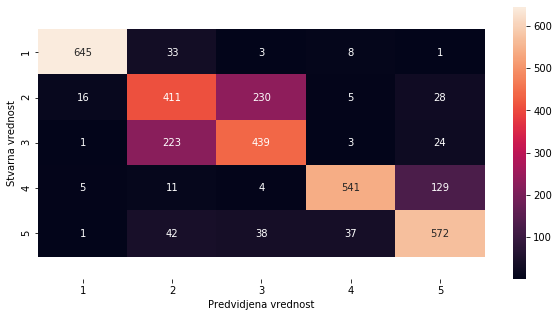

In [69]:
import seaborn
df_cm = pd.DataFrame(cm, index = classes, columns=classes)
plt.figure(figsize = (10, 5))
ax = seaborn.heatmap(df_cm, annot=True, fmt="d")
ax.set_ylabel('Stvarna vrednost')
ax.set_xlabel('Predvidjena vrednost')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)